# 1. Install Dependencies and Setup

In [7]:
!pip install tensorflow tensorflow opencv-python matplotlib

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)


In [8]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
alabaster                     0.7.12
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binary

In [9]:
import tensorflow as tf
import os

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [12]:
import cv2
import imghdr

In [13]:
data_dir = 'data' 

In [14]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [15]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1856 files belonging to 2 classes.


In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
batch = data_iterator.next()

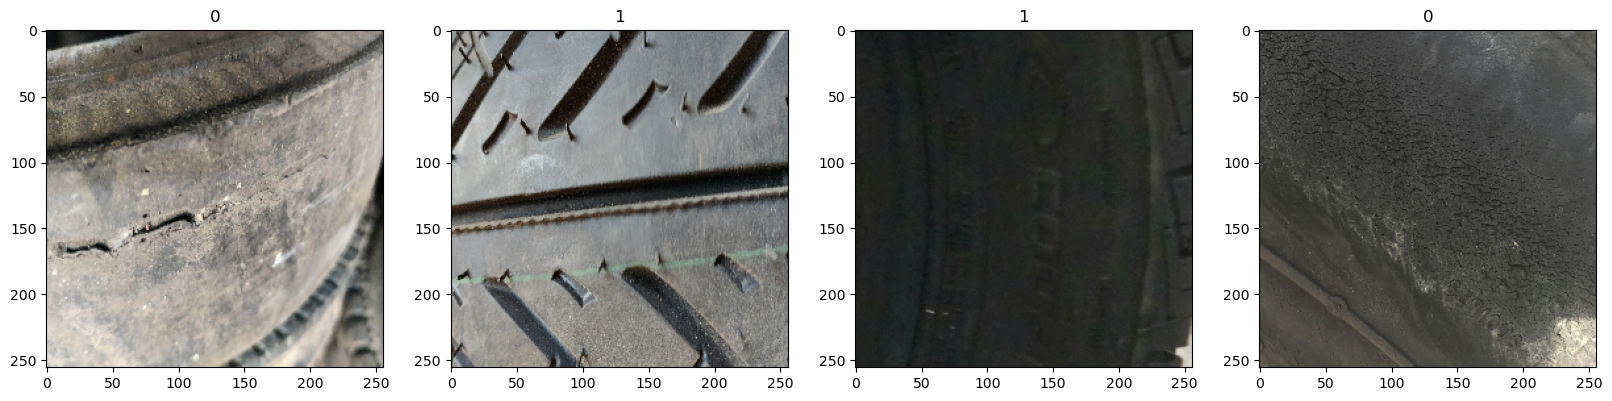

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [21]:
data = data.map(lambda x,y: (x/255, y))

In [22]:
data.as_numpy_iterator().next()

(array([[[[0.2931449 , 0.2931449 , 0.28530177],
          [0.2999693 , 0.2999693 , 0.29212615],
          [0.33622113, 0.34214926, 0.3391852 ],
          ...,
          [0.22375919, 0.23057576, 0.2374539 ],
          [0.3903418 , 0.3962318 , 0.3981696 ],
          [0.4185891 , 0.4244791 , 0.4264169 ]],
 
         [[0.3029872 , 0.3029872 , 0.29911157],
          [0.30100325, 0.30100325, 0.29712763],
          [0.2782935 , 0.28419164, 0.28124258],
          ...,
          [0.26214832, 0.2660699 , 0.27391303],
          [0.35793546, 0.36185703, 0.36970016],
          [0.37860772, 0.3825293 , 0.39037243]],
 
         [[0.28734675, 0.28734675, 0.28734675],
          [0.28136513, 0.28136513, 0.28136513],
          [0.288197  , 0.288197  , 0.288197  ],
          ...,
          [0.29027268, 0.29419425, 0.3020374 ],
          [0.28131104, 0.2852326 , 0.29307574],
          [0.31494337, 0.31886494, 0.32670808]],
 
         ...,
 
         [[0.15683211, 0.16083027, 0.1588312 ],
          [0.14403

# 5. Split Data

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [24]:
train_size

40

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [32]:
logdir='logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
40/40 [==============================] - 49s 1s/step - loss: 0.5678 - accuracy: 0.7000 - val_loss: 0.6062 - val_accuracy: 0.6818
Epoch 2/20
40/40 [==============================] - 47s 1s/step - loss: 0.5330 - accuracy: 0.7242 - val_loss: 0.5577 - val_accuracy: 0.6989
Epoch 3/20
40/40 [==============================] - 47s 1s/step - loss: 0.4887 - accuracy: 0.7672 - val_loss: 0.5400 - val_accuracy: 0.7074
Epoch 4/20
40/40 [==============================] - 48s 1s/step - loss: 0.4726 - accuracy: 0.7695 - val_loss: 0.5729 - val_accuracy: 0.7216
Epoch 5/20
40/40 [==============================] - 55s 1s/step - loss: 0.4337 - accuracy: 0.7992 - val_loss: 0.5690 - val_accuracy: 0.7614
Epoch 6/20
40/40 [==============================] - 63s 1s/step - loss: 0.3690 - accuracy: 0.8258 - val_loss: 0.6328 - val_accuracy: 0.7358
Epoch 7/20
40/40 [==============================] - 54s 1s/step - loss: 0.3324 - accuracy: 0.8469 - val_loss: 0.6977 - val_accuracy: 0.7472
Epoch 8/20
40/40 [==

# 8. Plot Performance

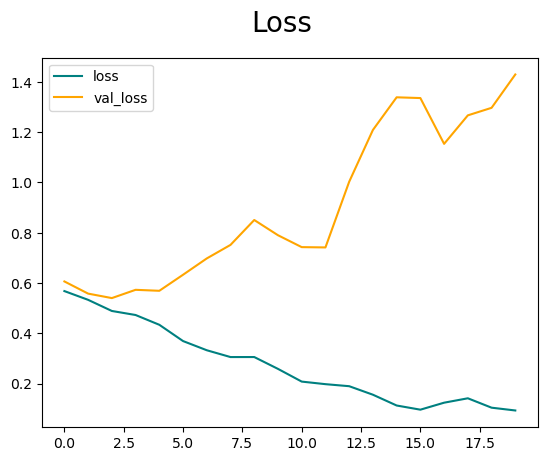

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

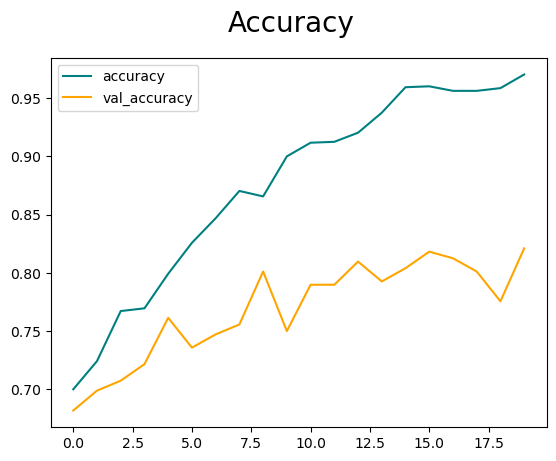

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 82ms/step


In [41]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.7826087, shape=(), dtype=float32) tf.Tensor(0.75, shape=(), dtype=float32) tf.Tensor(0.79375, shape=(), dtype=float32)


# 10. Test

In [52]:
import cv2

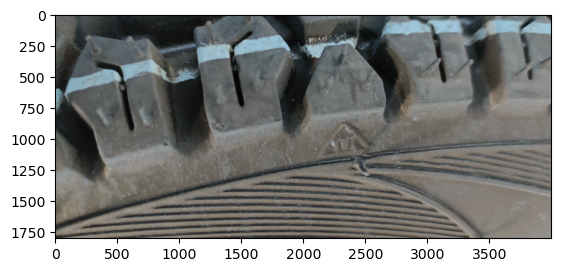

In [53]:
img = cv2.imread('data1.jpg')
plt.imshow(img)
plt.show()

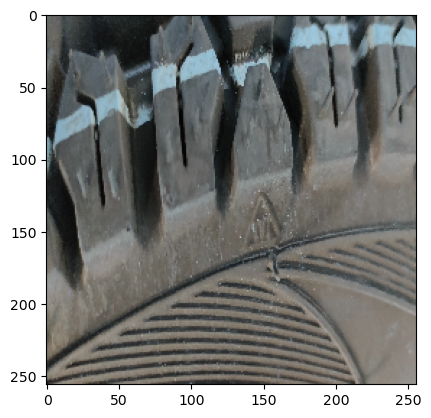

In [54]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [55]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 31ms/step


In [56]:
yhat

array([[1.]], dtype=float32)

In [60]:
if yhat > 0.5: 
    print(f'Tyre is Good')
else:
    print(f'Tyre is Defective')

Tyre is Good


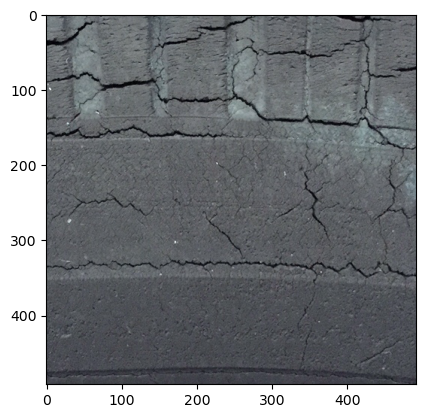

In [61]:
img = cv2.imread('data2.jpg')
plt.imshow(img)
plt.show()

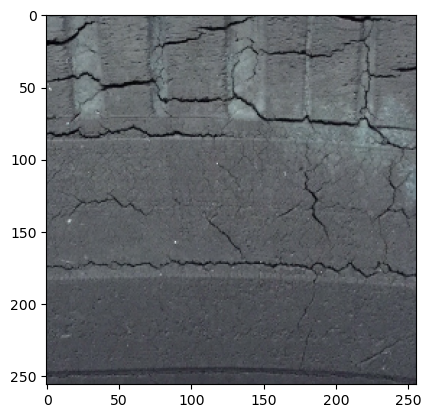

In [62]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [63]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 32ms/step


In [64]:
if yhat > 0.5: 
    print(f'Tyre is Good')
else:
    print(f'Tyre is Defective')

Tyre is Defective


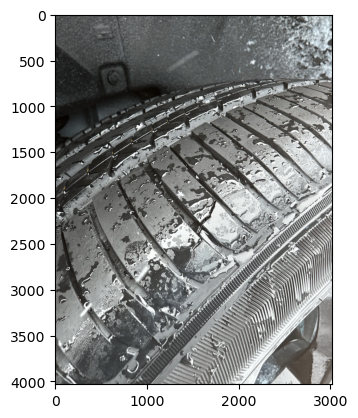

In [66]:
img = cv2.imread('data3.jpg')
plt.imshow(img)
plt.show()

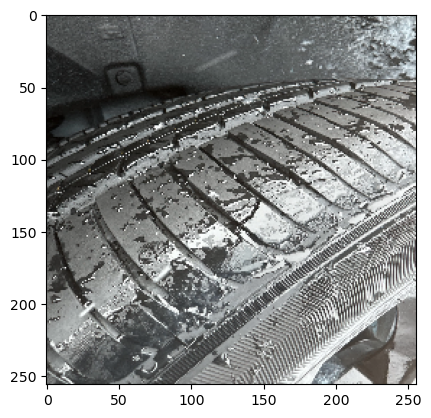

In [67]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [68]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 36ms/step


In [69]:
if yhat > 0.5: 
    print(f'Tyre is Good')
else:
    print(f'Tyre is Defective')

Tyre is Defective


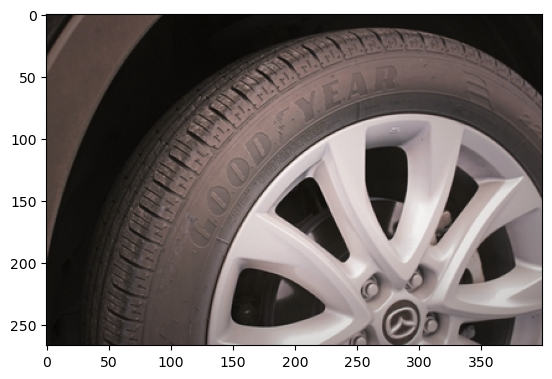

In [70]:
img = cv2.imread('data4.jpg')
plt.imshow(img)
plt.show()

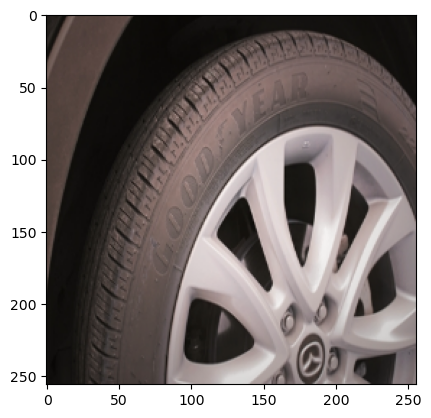

In [71]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [72]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 36ms/step


In [73]:
if yhat > 0.5: 
    print(f'Tyre is Good')
else:
    print(f'Tyre is Defective')

Tyre is Good


# 11. Save the Model

In [103]:
from tensorflow.keras.models import load_model

In [104]:
model.save(os.path.join('models','assessTyre.h5'))

In [105]:
new_model = load_model('models/assessTyre.h5')

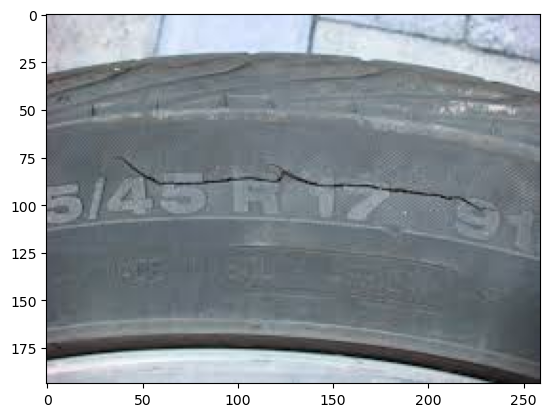

In [122]:
img = cv2.imread('data5.jpg')
plt.imshow(img)
plt.show()

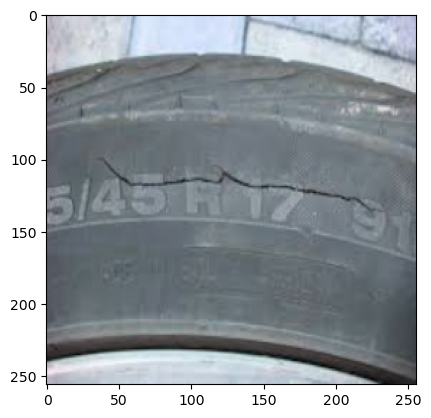

In [123]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [124]:
yhat = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 131ms/step


In [125]:
if yhat > 0.5: 
    print(f'Tyre is Good')
else:
    print(f'Tyre is Defective')

Tyre is Defective
